# Getting Started with cuML's accelerator mode (cuml.accel)


cuML is a Python GPU library for accelerating machine learning models using a scikit-learn-like API.

cuML now has an accelerator mode (cuml.accel) which allows you to bring accelerated computing to existing workflows with zero code changes required. In addition to scikit-learn, cuml.accel also provides acceleration to algorithms found in umap-learn (UMAP) and hdbscan (HDBSCAN).

This notebook is a brief introduction to cuml.accel.

**Author:** Mitesh Patel, Allison Ding <br>
**Date:** October 3, 2025

# ⚠️ Verify your setup

First, we'll verfiy that we are running on an NVIDIA GPU:

In [1]:
!nvidia-smi

Sun Oct  5 21:26:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.09              Driver Version: 580.82.09      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GB10                    Off |   0000000F:01:00.0 Off |                  N/A |
| N/A   38C    P0              5W /  N/A  | Not Supported          |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

With classical machine learning, there is a wide range of interesting problems we can explore. In this tutorial we'll examine 3 of the more popular use cases: classification, clustering, and dimensionality reduction.

# GPU-Accelerated Machine Learning

The notebook magic command `%load_ext cuml.accel` enables automatic GPU acceleration for machine learning code written with libraries like  UMAP and HDBSCAN, so models can train and run on NVIDIA GPUs without code changes or manual conversions. 

After activating this extension, supported estimators and algorithms are dispatched to the GPU for faster computation, and any operations not yet accelerated will seamlessly fall back to CPU execution. This approach is ideal for accelerating existing workflows in Jupyter or IPython environments, allowing significant speedups with minimal effort

In [2]:
%load_ext cuml.accel

# Classification

In [3]:
import time
start_time = time.time()

Let's load a dataset and see how we can use scikit-learn to classify that data.  For this example we'll use the Coverage Type dataset, which contains a number of features that can be used to predict forest cover type, such as elevation, aspect, slope, and soil-type.

More information on this dataset can be found at https://archive.ics.uci.edu/dataset/31/covertype.

In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

# Column names for the dataset (from UCI Covertype description)
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
           'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
           'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13',
           'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
           'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
           'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
           'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

data = pd.read_csv(url, header=None)
data.columns=columns

In [6]:
data.shape

(581012, 55)

Next, we'll separate out the classification variable (Cover_Type) from the rest of the data. This is what we will aim to predict with our classification model. We can also split our dataset into training and test data using the scikit-learn train_test_split function.

In [7]:
X, y = data.drop('Cover_Type', axis=1), data['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now that we have our dataset split, we're ready to run a model. To start, we will just run the model using the sklearn library with a starting max depth of 5 and all of the features. Note that we can set n_jobs=-1 to utilize all available CPU cores for fitting the trees -- this will ensure we get the best performance possible on our system's CPU.

In [ ]:
%%time
clf = LinearSVC()
clf.fit(X_train, y_train)

In about 2 minutes, we were able to fit our tree model using scikit-learn. This is not bad! Let's use the model we just trained to predict coverage types in our test dataset and take a look at the accuracy of our model.

In [ ]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

We can also print out a full classification report to better understand how we predicted different Coverage_Type categories.

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.39      0.28      0.33     42371
           2       0.54      0.75      0.63     56772
           3       0.65      0.61      0.63      7146
           4       0.00      0.00      0.00       546
           5       0.00      0.00      0.00      1907
           6       0.00      0.00      0.00      3454
           7       0.00      0.00      0.00      4007

    accuracy                           0.51    116203
   macro avg       0.23      0.23      0.23    116203
weighted avg       0.45      0.51      0.46    116203



/home/nvidia/miniconda3/envs/rapids-25.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nvidia/miniconda3/envs/rapids-25.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nvidia/miniconda3/envs/rapids-25.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [11]:
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

12.401145458221436


With scikit-learn, we built a model that was able to be trained in just a couple minutes. From the accuracy report, we can see that we predicted the correct class around 70% of the time, which is not bad but could certainly be improved.

Often we want to run several different random forest models in order to optimize our hyperparameters. For example, we may want to increase the number of estimators, or modify the maximum depth of our tree. When running dozens or hundreds of different hyperparameter combinations, things start to become quite slow and iteration takes a lot longer.

We provide some sample code utilizing GridSearchCV below to show what this process might look like. All of these combinations would take a LONG time to run if we spend 2 minutes fitting each model.

In [12]:
"""
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
"""

"\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid to search over\nparam_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'bootstrap': [True, False]\n}\n\ngrid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\n"

With a model that runs in just seconds, we can perform hyperparameter optimization using a method like the grid search shown above, and have results in just minutes instead of hours.

# CPU Fallback

There are some algorithms and functionality from scikit-learn, UMAP, and HDBSCAN that are *not* implemented in cuML. For cases where the underlying functionality is not supported on GPU, the cuML accelerator will gracefully fall back and execute on the CPU instead.

In [13]:
from sklearn.neighbors import KernelDensity
import numpy as np

X = np.concatenate((np.random.normal(0, 1, 10000),
                    np.random.normal(5, 1, 10000)))[:, np.newaxis]

In [14]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X)

,bandwidth,0.5
,algorithm,'auto'
,kernel,'gaussian'
,metric,'euclidean'
,atol,0
,rtol,0
,breadth_first,True
,leaf_size,40
,metric_params,None


In [15]:
print(kde.score_samples(X))

[-2.03555686 -1.81195669 -1.78476911 ... -3.20381041 -1.73643757
 -2.82360998]


We'll now take a look at a clustering example using HDBSCAN.

# Clustering

Clustering is an important data science workflow because it helps uncover hidden patterns and structures within data without requiring labeled outcomes. In practice, with high dimensional data it can be difficult to discern whether the clusters we've chosen are good or not. One way to determine the quality of our clustering is with sklearn's [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score), which we'll examine shortly.

HDBSCAN is a popular density-based clustering algorithm that is highly flexible. We'll load a toy sklearn dataset to illustrate how HDBSCAN can be accelerated with cuml.accel.

In [16]:
import time
start_time = time.time()

In [17]:
import hdbscan
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

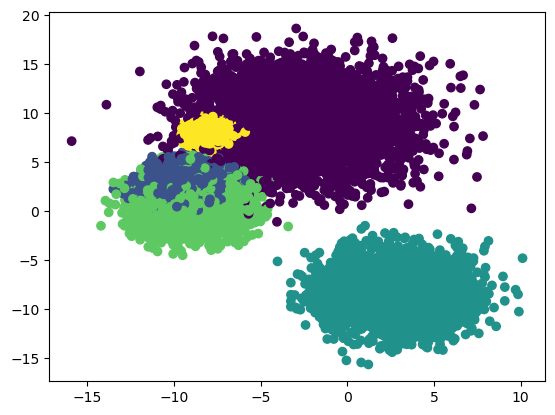

In [18]:
N = 20000
K = 100

X, y = make_blobs(
    n_samples=N,
    n_features=K,
    centers=5,
    cluster_std=[3,1,2,1.5,0.5],
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [19]:
clusterer = hdbscan.HDBSCAN()
%time clusterer.fit(X)

CPU times: user 213 ms, sys: 208 ms, total: 421 ms
Wall time: 597 ms


,min_cluster_size,5
,min_samples,None
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


In [20]:
print(silhouette_score(X, clusterer.labels_))

0.7352694189002873


In [21]:
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

2.456059455871582


# Dimensionality Reduction

UMAP is a popular dimensionality reduction technique that is used for both data visualization and as preprocessing for downstream modeling due to its ability to balance preserving both local and global structure of high-dimensional data. To learn more about how it works, visit the [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/).

To explore how cuML can accelerate UMAP, let's load in another dataset from UCI. We'll use the Human Activity Recognition (HAR) dataset, which was created from recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O /tmp/HAR_data.zip

In [ ]:
!unzip /tmp/HAR_data.zip -d /tmp/HAR_data/

In [24]:
import time
start_time = time.time()

In [25]:
import pandas as pd

X_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/X_train.txt", sep="\s+", header=None)
y_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/y_train.txt", sep="\s+", header=None)
X_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/X_test.txt", sep="\s+", header=None)
y_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/y_test.txt", sep="\s+", header=None)
labels = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/activity_labels.txt", sep="\s+", header=None)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_238331/4099239257.py:3: SyntaxWarning: invalid escape sequence '\s'
  X_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/X_train.txt", sep="\s+", header=None)
/tmp/ipykernel_238331/4099239257.py:4: SyntaxWarning: invalid escape sequence '\s'
  y_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/y_train.txt", sep="\s+", header=None)
/tmp/ipykernel_238331/4099239257.py:5: SyntaxWarning: invalid escape sequence '\s'
  X_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset

In [26]:
X_train.shape

(7352, 561)

Let's take a look at the activity labels to better understand the data we're working with. We can see that the sensors have grouped activities into 6 different classes.

In [27]:
labels

,0,1
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [28]:
from sklearn.preprocessing import StandardScaler

# Scale the data before applying UMAP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


Let's run UMAP with some basic parameters and explore a lower-dimensionality projection of this dataset.

In [29]:
import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, min_dist=0.0)

In [30]:
%%time

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)

[2025-10-05 21:26:31.169] [CUML] [info] build_algo set to brute_force_knn because random_state is given
CPU times: user 170 ms, sys: 61.5 ms, total: 232 ms
Wall time: 481 ms


It's often quite interesting to visualize the resulting projection of the embeddings created by UMAP. In this case, let's take a look at the now 2-dimensional dataset.

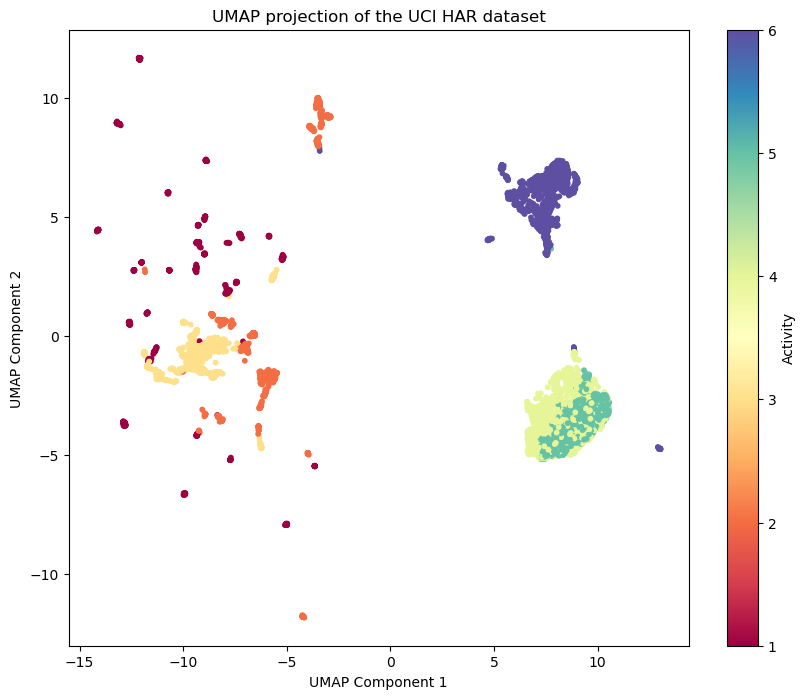

In [31]:
import matplotlib.pyplot as plt

# Plot the UMAP result
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(label="Activity")
plt.title("UMAP projection of the UCI HAR dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


It's interesting to see how our different categories are grouped in relation to one another.

We can look at the trustworthiness score to better understand how well the structure of the original dataset was preserved by our 2D projection

In [32]:
from sklearn.manifold import trustworthiness
trustworthiness(X_train, X_train_umap, n_neighbors=15)

np.float64(0.9709711206340002)

It looks like this projection is a great representation of our full dataset.

Let's now run the same thing with the accelerator turned on.

In [33]:
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

4.420806407928467
